<a href="https://colab.research.google.com/github/jemalmgr/AH2179/blob/main/Hand_In_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AH2179 Hand-In Assignment 3
## Reveal the most representative day-types based on your analysis
By Jennifer Malmgren

### Data preparation

In [1]:
# Imports

from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
import sklearn.metrics.pairwise as dis_lib
from dateutil.relativedelta import relativedelta
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib import colors

In [2]:
# Mount drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Create dataframe for training data

train_path = '/content/drive/MyDrive/Samhällsbyggnadsprogrammet/AH2179/Exercise 5/dataset_exercise_5_clustering_highway_traffic.csv'
train_df = pd.read_csv(train_path, sep=';')
train_df.sort_values(["Date", "Interval_5"])
train_df

,PORTAL,Date,time_from,time_to,Interval_5,SPEED_MS_AVG,flow
0,"E4S 56,780",20210101,00:00:00,00:05:00,0,18.56,39
1,"E4S 56,780",20210101,00:05:00,00:10:00,1,20.39,18
2,"E4S 56,780",20210101,00:10:00,00:15:00,2,19.27,26
3,"E4S 56,780",20210101,00:15:00,00:20:00,3,19.52,52
4,"E4S 56,780",20210101,00:20:00,00:25:00,4,20.52,52
...,...,...,...,...,...,...,...
104838,"E4S 56,780",20211231,23:35:00,23:40:00,283,19.58,115
104839,"E4S 56,780",20211231,23:40:00,23:45:00,284,19.47,87
104840,"E4S 56,780",20211231,23:45:00,23:50:00,285,19.77,130
104841,"E4S 56,780",20211231,23:50:00,23:55:00,286,18.79,129


In [4]:
# Check number of unique days

train_dates = np.unique(train_df[['Date']].values.ravel())
train_days = len(train_dates)
print(f'First date: {train_dates[0]}\nLast date: {train_dates[-1]}\nNumber of unique dates: {train_days}')

First date: 20210101
Last date: 20211231
Number of unique dates: 365


In [5]:
# Group dataframe by date

train_df_by_date = train_df.groupby(["Date"])
train_df_by_date.head()

,PORTAL,Date,time_from,time_to,Interval_5,SPEED_MS_AVG,flow
0,"E4S 56,780",20210101,00:00:00,00:05:00,0,18.56,39
1,"E4S 56,780",20210101,00:05:00,00:10:00,1,20.39,18
2,"E4S 56,780",20210101,00:10:00,00:15:00,2,19.27,26
3,"E4S 56,780",20210101,00:15:00,00:20:00,3,19.52,52
4,"E4S 56,780",20210101,00:20:00,00:25:00,4,20.52,52
...,...,...,...,...,...,...,...
104555,"E4S 56,780",20211231,00:00:00,00:05:00,0,21.21,33
104556,"E4S 56,780",20211231,00:05:00,00:10:00,1,20.44,32
104557,"E4S 56,780",20211231,00:10:00,00:15:00,2,19.11,34
104558,"E4S 56,780",20211231,00:15:00,00:20:00,3,19.77,24


In [6]:
# Create a matrix filled with NaN values

nintvals = 288
vectorized_train_dataset = np.zeros((train_days, nintvals))
vectorized_train_dataset.fill(np.nan)
vectorized_train_dataset

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [7]:
# Loop through the unique days; for each day, extract the flow and populate 'vectorized_day_dataset'

for i in range(0, train_days):
    df_t = train_df_by_date.get_group(train_dates[i])
    for j in range(len(df_t)):
        df_t = train_df_by_date.get_group(train_dates[i])
        vectorized_train_dataset[i, df_t.iloc[j]["Interval_5"]] = df_t.iloc[j]["flow"]

print(vectorized_train_dataset.shape)
print(vectorized_train_dataset)

(365, 288)
[[ 39.  18.  26. ...  32.  39.  34.]
 [ 30.  32.  27. ...  44.  41.  39.]
 [ 36.  44.  52. ...  50.  45.  23.]
 ...
 [ 20.  34.  31. ...  38.  42.  36.]
 [ 36.  40.  25. ...  38.  56.  35.]
 [ 33.  32.  34. ... 130. 129. 117.]]


### Data exploration

In [8]:
# Check rate of missing values

print('Number of NaNs:',np.sum(np.isnan(vectorized_train_dataset)))
print('Rate of NaNs:',np.sum(np.isnan(vectorized_train_dataset))/(train_days*nintvals))

Number of NaNs: 277
Rate of NaNs: 0.0026350837138508373


In [9]:
# Check the number of missing values per time interval

train_nans_per_interval = np.sum(np.isnan(vectorized_train_dataset),0)
print(train_nans_per_interval.shape)
print(train_nans_per_interval)

(288,)
[1 2 4 3 3 3 5 9 2 3 4 0 5 4 1 2 2 3 0 2 1 3 1 1 5 5 5 3 2 6 6 4 9 3 3 7 2
 3 5 5 2 6 2 0 2 1 2 2 3 3 1 5 1 2 2 1 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 2 1 1 1 2 1 0 1 2 0 2 2 0 0 1 1 1 2 1 2 2 2 1 2]


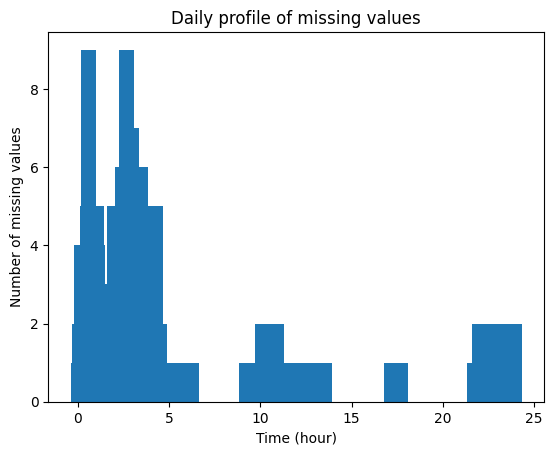

In [10]:
# Make a daily profile of the missing values

fig, ax = plt.subplots()
x_axis = np.arange(0, nintvals, 1, dtype=int)

x_axis_hours = []

for i in range(0, len(x_axis)):
  x_axis_hours.append(float(x_axis[i]*5)/60)

ax.bar(x_axis_hours,height=train_nans_per_interval)

ax.set_ylabel('Number of missing values')
ax.set_xlabel('Time (hour)')
ax.set_title('Daily profile of missing values')

plt.show()

In [11]:
# Check the number of days with missing values

nans_per_day = np.sum(np.isnan(vectorized_train_dataset),1)
print('Number of days with NaNs:',np.size(np.where(nans_per_day > 0),1))

Number of days with NaNs: 28


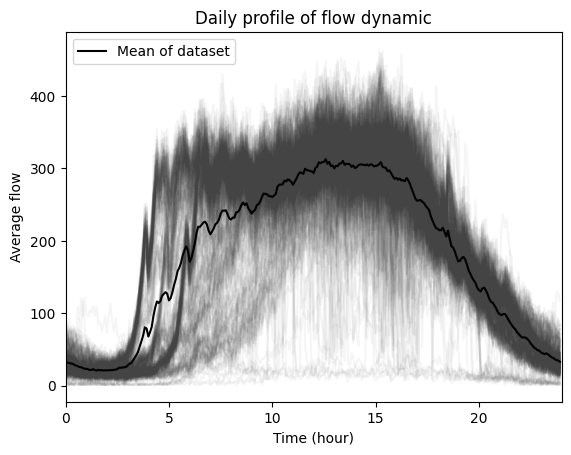

In [12]:
# Create a daily profile of flow dynamic

fig, ax = plt.subplots()
ax.plot(np.array([x_axis_hours,]*train_days).transpose(), vectorized_train_dataset.transpose(), color='#444444', alpha=0.05)
ax.plot(x_axis_hours,np.transpose(np.nanmean(vectorized_train_dataset,0)), color='black', label='Mean of dataset')
ax.set_ylabel('Average flow')
ax.set_xlabel('Time (hour)')
plt.xlim(0,24)
ax.set_title('Daily profile of flow dynamic')
ax.legend()
plt.show()

In [13]:
# Store the day of the week for each unique date

day_of_week = np.zeros((train_days))

for i in range(0, train_days):
    day_dt = datetime.datetime.strptime(str(train_dates[i]), '%Y%m%d')
    day_of_week[i] = day_dt.isoweekday()

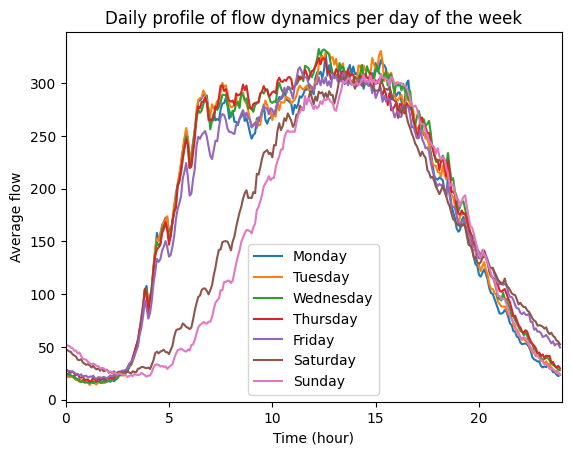

In [14]:
# Create a daily profile of flow dynamics per day of the week

day_dict = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}

fig, ax = plt.subplots()
for i in range(1, 7+1):
    day_of_week_index_t = np.where(day_of_week == i)
    ndays_t = np.size(day_of_week_index_t[0])
    ax.plot(x_axis_hours, np.nanmean(vectorized_train_dataset[day_of_week_index_t[0],:].transpose(),1), label=day_dict[i])

ax.set_ylabel('Average flow')
ax.set_xlabel('Time (hour)')
plt.xlim(0, 24)
ax.set_title('Daily profile of flow dynamics per day of the week')
ax.legend()
plt.show()

### Clustering

In [15]:
# Prepare dataset without missing values

vectorized_train_dataset_no_nans = vectorized_train_dataset[np.where(nans_per_day == 0)[0],:]
print(vectorized_train_dataset_no_nans.shape)
print(vectorized_train_dataset_no_nans)

(337, 288)
[[ 39.  18.  26. ...  32.  39.  34.]
 [ 30.  32.  27. ...  44.  41.  39.]
 [ 36.  44.  52. ...  50.  45.  23.]
 ...
 [ 20.  34.  31. ...  38.  42.  36.]
 [ 36.  40.  25. ...  38.  56.  35.]
 [ 33.  32.  34. ... 130. 129. 117.]]


In [16]:
# Check number of days with no missing values

train_dates_no_nans = train_dates[np.where(nans_per_day == 0)[0]]
train_days_no_nans = len(train_dates_no_nans)
print(f'First date: {train_dates_no_nans[0]}\nLast date: {train_dates_no_nans[-1]}\nNumber of unique dates: {train_days_no_nans}')

First date: 20210101
Last date: 20211231
Number of unique dates: 337


In [17]:
# Make clusters

n_clusters_range = [3, 5, 7, 9, 12, 15]
eps_range = [500]
min_samples_range = [2, 3, 5]
clusters = []

for n_clusters in n_clusters_range:
  kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(vectorized_train_dataset_no_nans)
  clusters.append(['KMeans', n_clusters, None, None, kmeans.labels_, None, None, None, None, None])

for n_clusters in n_clusters_range:
  agglomerative = AgglomerativeClustering(n_clusters=n_clusters,metric='euclidean', linkage='ward').fit(vectorized_train_dataset_no_nans)
  clusters.append(['Agglomerative', n_clusters, None, None, agglomerative.labels_, None, None, None, None, None])

for eps in eps_range:
  for min_samples in min_samples_range:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(vectorized_train_dataset_no_nans)
    clusters.append(['DBSCAN', None, eps, min_samples, dbscan.labels_, None, None, None, None, None])

for n_clusters in n_clusters_range:
  gmm = GaussianMixture(n_components=n_clusters).fit(vectorized_train_dataset_no_nans).predict(vectorized_train_dataset_no_nans)
  clusters.append(['GMM', n_clusters, None, None, gmm, None, None, None, None, None])

### Evaluation

In [18]:
# External evaluation dataset

eval_path = '/content/drive/MyDrive/Samhällsbyggnadsprogrammet/AH2179/Exercise 5/evaluation_dataset_exercise_5_clustering_highway_traffic.csv'
eval_df = pd.read_csv(eval_path, sep=';')
eval_df.sort_values(["Date", "Interval_5"])
eval_df

,PORTAL,Date,time_from,time_to,Interval_5,SPEED_MS_AVG,flow
0,"E4S 56,780",20220108,00:00:00,00:05:00,0,16.74,35
1,"E4S 56,780",20220108,00:05:00,00:10:00,1,17.57,29
2,"E4S 56,780",20220108,00:10:00,00:15:00,2,16.94,32
3,"E4S 56,780",20220108,00:15:00,00:20:00,3,17.50,27
4,"E4S 56,780",20220108,00:20:00,00:25:00,4,16.21,31
...,...,...,...,...,...,...,...
22939,"E4S 56,780",20221230,23:35:00,23:40:00,283,19.83,43
22940,"E4S 56,780",20221230,23:40:00,23:45:00,284,19.01,35
22941,"E4S 56,780",20221230,23:45:00,23:50:00,285,19.72,45
22942,"E4S 56,780",20221230,23:50:00,23:55:00,286,20.64,49


In [19]:
eval_dates = np.unique(eval_df[['Date']].values.ravel())
eval_days = len(eval_dates)
print(f'First date: {eval_dates[0]}\nLast date: {eval_dates[-1]}\nNumber of unique dates: {eval_days}')

First date: 20220108
Last date: 20221230
Number of unique dates: 80


In [20]:
eval_df_by_date = eval_df.groupby(["Date"])
eval_df_by_date.head()

,PORTAL,Date,time_from,time_to,Interval_5,SPEED_MS_AVG,flow
0,"E4S 56,780",20220108,00:00:00,00:05:00,0,16.74,35
1,"E4S 56,780",20220108,00:05:00,00:10:00,1,17.57,29
2,"E4S 56,780",20220108,00:10:00,00:15:00,2,16.94,32
3,"E4S 56,780",20220108,00:15:00,00:20:00,3,17.50,27
4,"E4S 56,780",20220108,00:20:00,00:25:00,4,16.21,31
...,...,...,...,...,...,...,...
22656,"E4S 56,780",20221230,00:00:00,00:05:00,0,20.82,42
22657,"E4S 56,780",20221230,00:05:00,00:10:00,1,20.28,28
22658,"E4S 56,780",20221230,00:10:00,00:15:00,2,20.50,32
22659,"E4S 56,780",20221230,00:15:00,00:20:00,3,19.80,37


In [21]:
vectorized_eval_dataset = np.zeros((eval_days, nintvals))
vectorized_eval_dataset.fill(np.nan)
vectorized_eval_dataset

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [22]:
for i in range(0, eval_days):
    df_t = eval_df_by_date.get_group(eval_dates[i])
    for j in range(len(df_t)):
        df_t = eval_df_by_date.get_group(eval_dates[i])
        vectorized_eval_dataset[i, df_t.iloc[j]["Interval_5"]] = df_t.iloc[j]["flow"]

print(vectorized_eval_dataset.shape)
print(vectorized_eval_dataset)

(80, 288)
[[35. 29. 32. ... 62. 66. 71.]
 [44. 44. 51. ... 30. 31. 23.]
 [21. 22. 17. ... 20. 22. 22.]
 ...
 [17. 17. 20. ... 35. 25. 27.]
 [37. 25. 30. ... 37. 36. 49.]
 [42. 28. 32. ... 45. 49. 38.]]


In [23]:
print('Number of NaNs:', np.sum(np.isnan(vectorized_eval_dataset)))
print('Rate of NaNs:', np.sum(np.isnan(vectorized_eval_dataset)) / (eval_days * nintvals))
nans_per_day_eval = np.sum(np.isnan(vectorized_eval_dataset), 1)
print('Number of days with missing values:', np.size(np.where(nans_per_day_eval > 0)))
eval_dates_no_nans = eval_dates[np.where(nans_per_day_eval == 0)[0]]
eval_days_no_nans = len(eval_dates_no_nans)
print(f'First date: {eval_dates_no_nans[0]}\nLast date: {eval_dates_no_nans[-1]}\nFinal number of days in evaluation dataset: {eval_days_no_nans}')

vectorized_eval_dataset_no_nans = vectorized_eval_dataset[np.where(nans_per_day_eval == 0)[0], :]

Number of NaNs: 96
Rate of NaNs: 0.004166666666666667
Number of days with missing values: 11
First date: 20220108
Last date: 20221230
Final number of days in evaluation dataset: 69


In [24]:
def find_the_closest_centroid(centroids, new_day, from_interval: int, to_interval: int):
    closest_centroid = None
    closest_dist = None

    for i in range(0, len(centroids)):
        ed_t = dis_lib.paired_distances(centroids[i], new_day, metric='euclidean')
        if closest_centroid is None or closest_dist > ed_t:
            closest_centroid = i
            closest_dist = ed_t
    return closest_centroid

In [25]:
# Perform evaluation techniques

for i in range(len(clusters)):
  cluster_labels = clusters[i][4]

  # Internal evaluation
  clusters[i][5] = silhouette_score(vectorized_train_dataset_no_nans, cluster_labels) # Silhouette Score measures the quality of clusters, higher values indicate better separation.
  clusters[i][6] = davies_bouldin_score(vectorized_train_dataset_no_nans, cluster_labels) # Davies-Bouldin Score measures the average similarity between each cluster and its most similar cluster, lower values indicate better separation.
  clusters[i][7] = calinski_harabasz_score(vectorized_train_dataset_no_nans, cluster_labels) # Calinski-Harabasz Score measures the ratio of between-cluster variance to within-cluster variance, higher values indicate better separation.

  # External evalutation (evaluating short-term prediction performance)
  centroids = []

  for j in np.unique(cluster_labels):
    centroid = np.nanmean(vectorized_train_dataset_no_nans[np.where(cluster_labels == j)[0], :], 0).reshape(1, nintvals)
    centroids.append(centroid)

  n_past_intervals_for_classification = 5

  total_mae = 0
  total_mape = 0
  prediction_counts = 0

  for k in range(0, eval_days_no_nans):
      for l in range(n_past_intervals_for_classification, nintvals - 1):
        centroid_index = find_the_closest_centroid(centroids, vectorized_eval_dataset_no_nans[k].reshape(1, nintvals), l - n_past_intervals_for_classification, l)
        predicted_value = centroids[centroid_index][0, l + 1]
        mae_t = abs(predicted_value - vectorized_eval_dataset_no_nans[k][l + 1]) # Mean Absolute Error, lower values indicate better models
        mape_t = abs(predicted_value - vectorized_eval_dataset_no_nans[k][l + 1]) / float(vectorized_eval_dataset_no_nans[k][l + 1]) # Mean Absolute Percentage Error, lower values indicate better models
        total_mae += mae_t
        total_mape += mape_t
        prediction_counts += 1

  clusters[i][8] = total_mae/prediction_counts
  clusters[i][9] = total_mape/prediction_counts

In [26]:
result_df = pd.DataFrame(clusters, columns=['Algorithm', 'n_clusters', 'eps', 'min_samples', 'cluster_labels', 'Silhouette score', 'Davies-Bouldin score', 'Calinski-Harabasz score', 'MAE', 'MAPE'])
result_df

,Algorithm,n_clusters,eps,min_samples,cluster_labels,Silhouette score,Davies-Bouldin score,Calinski-Harabasz score,MAE,MAPE
0,KMeans,3.0,NaN,NaN,"[1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...",0.269241,1.358789,159.134213,31.399559,0.409407
1,KMeans,5.0,NaN,NaN,"[1, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, ...",0.229698,1.515830,114.694738,27.619318,0.277312
2,KMeans,7.0,NaN,NaN,"[5, 5, 5, 1, 1, 5, 3, 3, 5, 5, 3, 3, 3, 3, 3, ...",0.241332,1.481357,103.050630,25.326415,0.253731
3,KMeans,9.0,NaN,NaN,"[4, 4, 4, 5, 1, 4, 3, 3, 4, 4, 5, 3, 3, 5, 3, ...",0.216715,1.676599,86.615548,24.553252,0.244439
4,KMeans,12.0,NaN,NaN,"[4, 4, 4, 9, 1, 4, 9, 9, 4, 4, 5, 9, 9, 9, 9, ...",0.180512,1.617700,72.488151,23.352217,0.225660
5,KMeans,15.0,NaN,NaN,"[13, 4, 4, 9, 9, 4, 9, 9, 4, 4, 5, 9, 9, 9, 9,...",0.160506,1.650415,60.695231,22.701453,0.216801
6,Agglomerative,3.0,NaN,NaN,"[2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, ...",0.268112,1.313811,148.607605,30.988773,0.417042
7,Agglomerative,5.0,NaN,NaN,"[2, 2, 2, 1, 3, 2, 3, 3, 2, 2, 1, 3, 3, 3, 3, ...",0.263778,1.231404,118.054696,28.653847,0.290830
8,Agglomerative,7.0,NaN,NaN,"[2, 2, 2, 6, 3, 2, 3, 3, 2, 2, 1, 3, 3, 3, 3, ...",0.243157,1.513606,100.749684,24.767895,0.250174
9,Agglomerative,9.0,NaN,NaN,"[8, 3, 3, 6, 1, 3, 1, 1, 3, 3, 0, 1, 1, 1, 1, ...",0.233039,1.390687,84.412420,24.434278,0.236757


### Visualization

In [27]:
def assign_colors(n_clusters, days, assigments):

  days_colors = []
  color_to_cluster = []
  style_to_cluster = []
  weekend_colors = ['#67001f','#d6604d','#fdae61','#f46d43','#d53e4f','#9e0142','#f768a1','#f1c232']
  mixed_colors = ['#4d4d4d','#35978f','#bababa','#878787']
  weekday_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#cab2d6','#6a3d9a','#b15928','#8dd3c7','#bebada','#fb8072','#b3de69','#bc80bd','#fccde5','#ccebc5','#35978f','#80cdc1']

  cluster_id_weekdays_share = []
  cluster_id_weekend_share = []
  cluster_id_all_days = []

  for i in range(0,n_clusters):
      color_to_cluster.append(None)
      style_to_cluster.append(None)
      cluster_id_weekdays_share.append(0)
      cluster_id_weekend_share.append(0)
      cluster_id_all_days.append(0)

  for i in range(0,len(days)):
      if assigments[i] is not None:
        cluster_id_all_days[assigments[i]] += 1
        if '-' in str(days[i]):
          pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
        else:
          pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')

        if int(pomT.weekday()) < 5:
          cluster_id_weekdays_share[assigments[i]] += 1
        else:
          cluster_id_weekend_share[assigments[i]] += 1

  print('cluster_id_weekdays_share',cluster_id_weekdays_share)
  print('cluster_id_weekend_share',cluster_id_weekend_share)
  for i in range(0,len(days)):
    if assigments[i] is not None:
      cluster_idx = assigments[i]
      if '-' in str(days[i]):
        pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
      else:
        pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
      if color_to_cluster[assigments[i]] is None:
        if cluster_id_weekend_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
          color_to_cluster[assigments[i]] = weekend_colors.pop()
          style_to_cluster[assigments[i]] = ':'
        elif cluster_id_weekdays_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
          color_to_cluster[assigments[i]] = weekday_colors.pop(0)
          style_to_cluster[assigments[i]] = '-'
        else:
          color_to_cluster[assigments[i]] = mixed_colors.pop()
          style_to_cluster[assigments[i]] = ':'

      days_colors.append(color_to_cluster[assigments[i]])
    else:
      days_colors.append(None)

  return days_colors,color_to_cluster,style_to_cluster

In [28]:
def calmap(ax, year, data, days, assigments, n_clusters,days_colors,color_to_cluster, limit_graphics=False):

  ax.tick_params('x', length=0, labelsize="medium", which='major')
  ax.tick_params('y', length=0, labelsize="x-small", which='major')

  xticks, labels = [], []
  start = datetime.datetime(year,1,1).weekday()

  for month in range(1,13):
    first = datetime.datetime(year, month, 1)
    last = first + relativedelta(months=1, days=-1)

    y0 = first.weekday()
    y1 = last.weekday()
    x0 = (int(first.strftime("%j"))+start-1)//7
    x1 = (int(last.strftime("%j"))+start-1)//7

    P = [(x0,y0), (x0,7), (x1,7), (x1,y1+1), (x1+1,y1+1), (x1+1,0), (x0+1,0), (x0+1,y0)]

    xticks.append(x0 +(x1-x0+1)/2)
    labels.append(first.strftime("%b"))
    poly = Polygon(P, edgecolor="black", facecolor="None", linewidth=1, zorder=20, clip_on=False)

    ax.add_artist(poly)

    line = Line2D([0,53],[5,5],linewidth=1, zorder = 20,color="black",linestyle='dashed')
    ax.add_artist(line)

    if not limit_graphics:
      ax.set_xticks(xticks)
      ax.set_xticklabels(labels)
      ax.set_yticks(0.5 + np.arange(7))
      ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
      ax.set_title("{}".format(year), weight="semibold")
    else:
      plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
      plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    valid = datetime.datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime.datetime(year, 12, 31).weekday()

    data[valid+1:,x1] = np.nan

    for i in range(0,len(days)):
      if '-' in str(days[i]):
        pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
      else:
        pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
      week_number = int(pomT.strftime("%W"))
      day_of_week = int(pomT.weekday())
      data[day_of_week,week_number] = assigments[i]

    act_date = datetime.datetime(year,1,1)
    while (act_date.year == year):
      week_number = int(act_date.strftime("%W"))
      day_of_week = int(act_date.weekday())
      doy_id = act_date.timetuple().tm_yday
      if doy_id<5 and week_number > 53:
          week_number = 0

      act_date = act_date + datetime.timedelta(days=1)

    cmap = plt.cm.spring
    cmap.set_bad(color='white')

    cmap = colors.ListedColormap(color_to_cluster)
    bounds=[-0.1]
    step = 1
    for i in range(0,n_clusters):
      bounds.append(i-0.1+step)
    norm = colors.BoundaryNorm(bounds, cmap.N)

    ax.imshow(data, extent=[0,53,0,7], zorder=10, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)

In [29]:
def make_calendar_visualization_figure(days,assigments,n_clusters,years,days_colors,color_to_cluster, save_figure: str = None, show_figure:bool = True, limit_graphics = False):

  fig = plt.figure(figsize=(8,1.5*len(years)), dpi=100)
  X = np.linspace(-1,1, 53*7)

  for i, obj in enumerate(years):
    pom_s = str(len(years))+'1'+str(i+1)
    ax = plt.subplot(int(pom_s), xlim=[0, 53], ylim=[0, 7], frameon=False, aspect=1)
    I = 1.2 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
    I = I.reshape(53,7).T
    I.fill(np.nan)
    calmap(ax, int(obj), I.reshape(53,7).T, days, assigments, n_clusters,days_colors,color_to_cluster, limit_graphics)

  if save_figure:
    plt.savefig(save_figure)

  if show_figure or save_figure is None:
    plt.tight_layout()
    plt.show()

In [30]:
def make_figure_centroids(x,y,color_to_cluster,style_to_cluster,cluster_ids,minY = None,maxY = None, save_figure: str = None, show_figure:bool = True):

  fig = plt.figure(figsize=(8,3))
  ax = fig.add_subplot(111)

  for i in range(0,len(x)):
    ax.plot(x[i],y[i],style_to_cluster[i], color=color_to_cluster[i], label=str(cluster_ids[i]))

  ax.set_xlabel('Time of day')
  ax.set_ylabel('Flow')

  if minY is not None and maxY is not None:
    ax.set_ylim([minY, maxY])
  plt.legend()

  if save_figure:
    plt.savefig(save_figure)

  if show_figure or save_figure is None:
    plt.tight_layout()
    plt.show()

Algorithm: KMeans
Parameters: (3, None, None)
cluster_id_weekdays_share [94, 8, 134]
cluster_id_weekend_share [26, 75, 0]


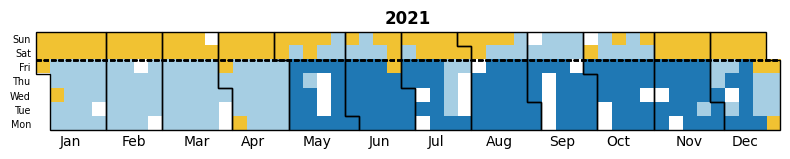

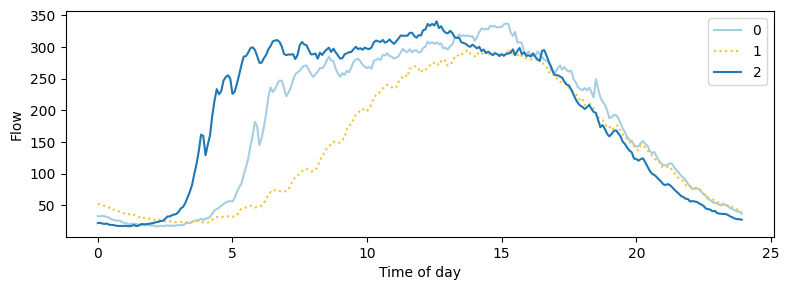

Algorithm: KMeans
Parameters: (5, None, None)
cluster_id_weekdays_share [61, 9, 85, 80, 1]
cluster_id_weekend_share [0, 76, 0, 23, 2]


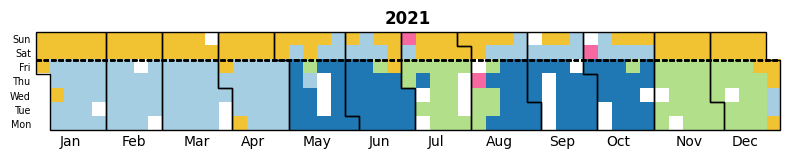

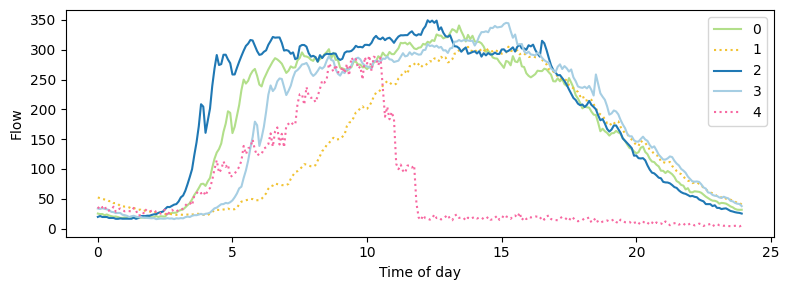

Algorithm: KMeans
Parameters: (7, None, None)
cluster_id_weekdays_share [39, 8, 81, 73, 1, 6, 28]
cluster_id_weekend_share [0, 57, 0, 0, 2, 42, 0]


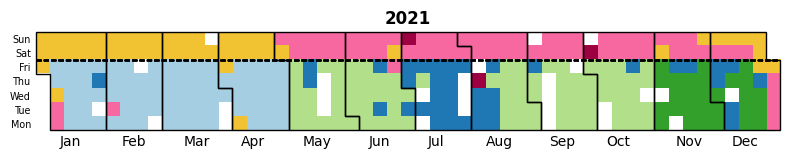

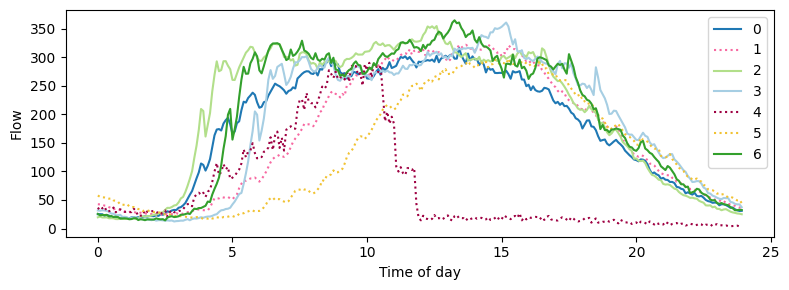

Algorithm: KMeans
Parameters: (9, None, None)
cluster_id_weekdays_share [28, 4, 65, 70, 6, 10, 34, 1, 18]
cluster_id_weekend_share [0, 43, 0, 0, 39, 17, 0, 2, 0]


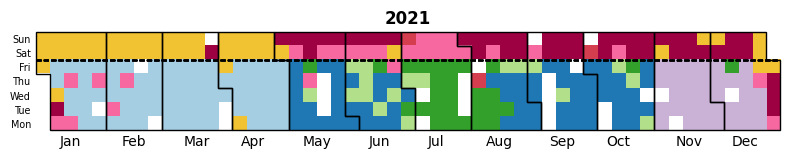

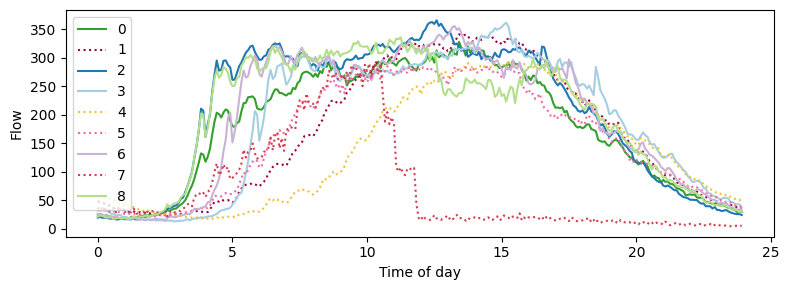

Algorithm: KMeans
Parameters: (12, None, None)
cluster_id_weekdays_share [27, 4, 64, 42, 5, 8, 34, 1, 18, 31, 1, 1]
cluster_id_weekend_share [0, 35, 0, 0, 16, 13, 0, 2, 0, 0, 35, 0]


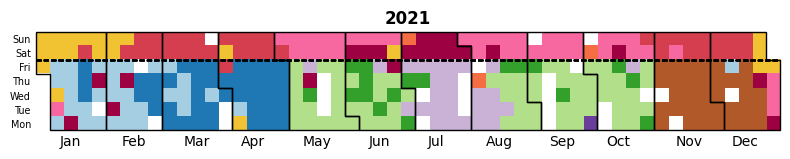

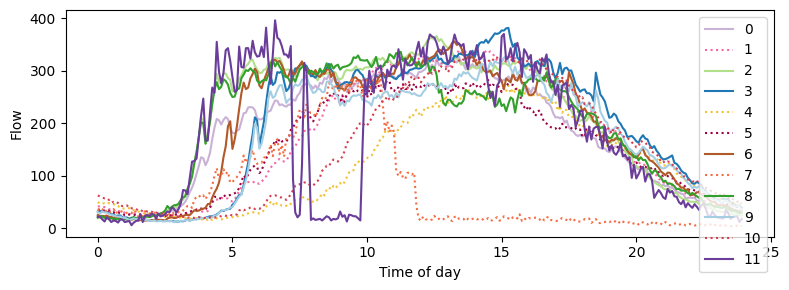

Algorithm: KMeans
Parameters: (15, None, None)
cluster_id_weekdays_share [27, 0, 64, 42, 2, 7, 34, 1, 18, 32, 1, 1, 0, 4, 3]
cluster_id_weekend_share [0, 17, 0, 0, 23, 5, 0, 2, 0, 0, 26, 0, 11, 2, 15]


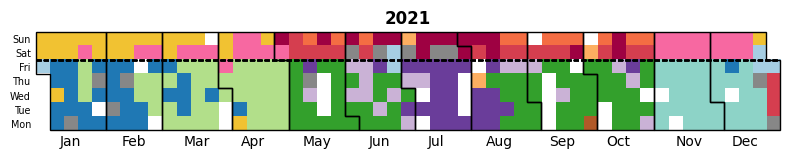

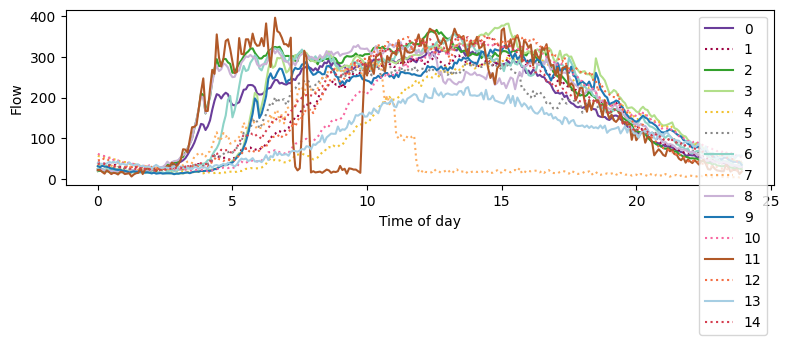

Algorithm: Agglomerative
Parameters: (3, None, None)
cluster_id_weekdays_share [102, 128, 6]
cluster_id_weekend_share [55, 0, 46]


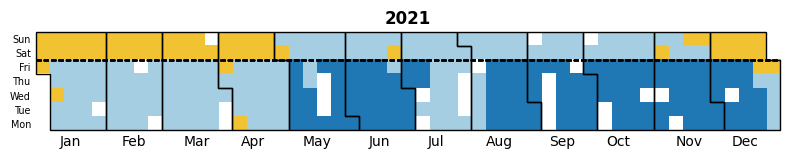

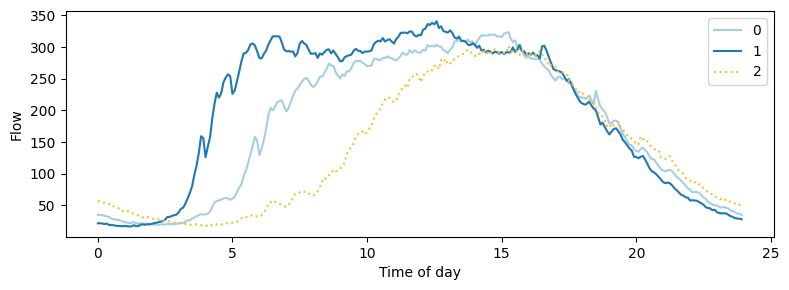

Algorithm: Agglomerative
Parameters: (5, None, None)
cluster_id_weekdays_share [128, 30, 6, 71, 1]
cluster_id_weekend_share [0, 53, 46, 0, 2]


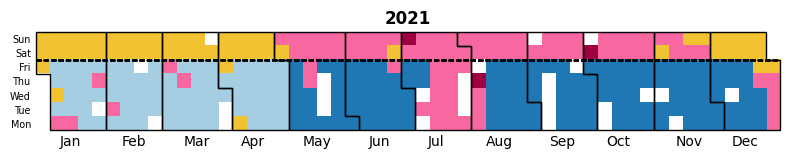

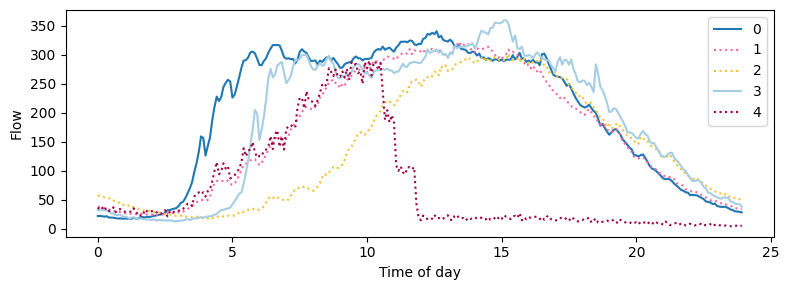

Algorithm: Agglomerative
Parameters: (7, None, None)
cluster_id_weekdays_share [38, 25, 6, 71, 1, 90, 5]
cluster_id_weekend_share [0, 11, 46, 0, 2, 0, 42]


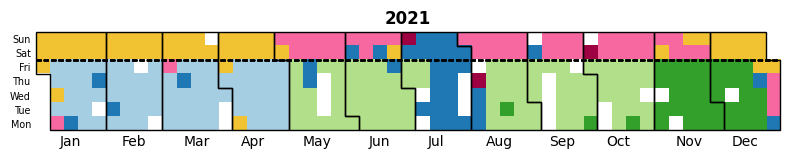

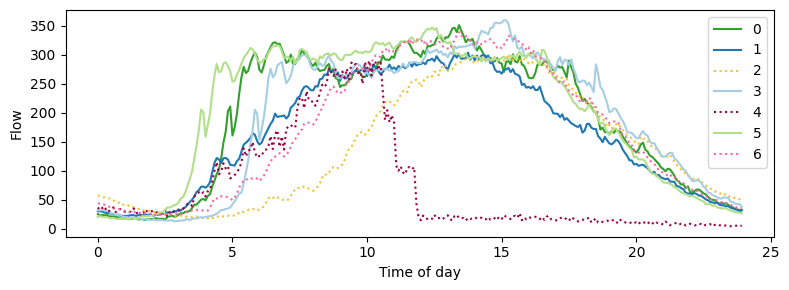

Algorithm: Agglomerative
Parameters: (9, None, None)
cluster_id_weekdays_share [25, 71, 90, 3, 1, 5, 5, 33, 3]
cluster_id_weekend_share [11, 0, 0, 44, 2, 0, 42, 0, 2]


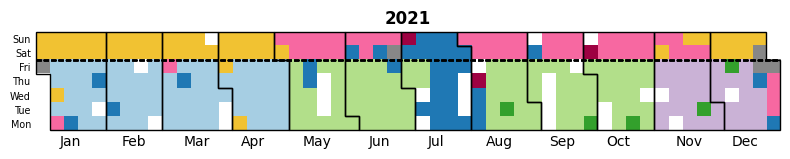

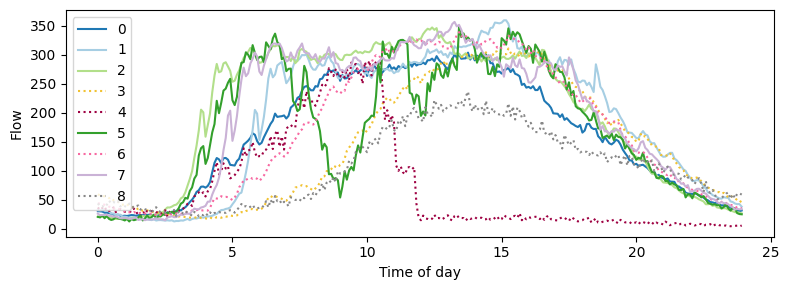

Algorithm: Agglomerative
Parameters: (12, None, None)
cluster_id_weekdays_share [3, 33, 5, 32, 8, 28, 5, 17, 3, 1, 43, 58]
cluster_id_weekend_share [44, 0, 0, 0, 11, 0, 42, 0, 2, 2, 0, 0]


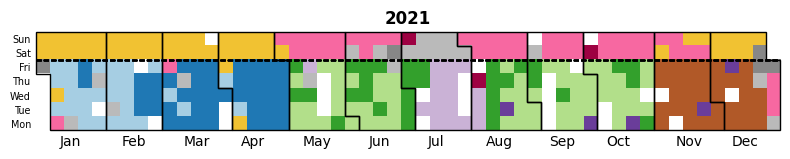

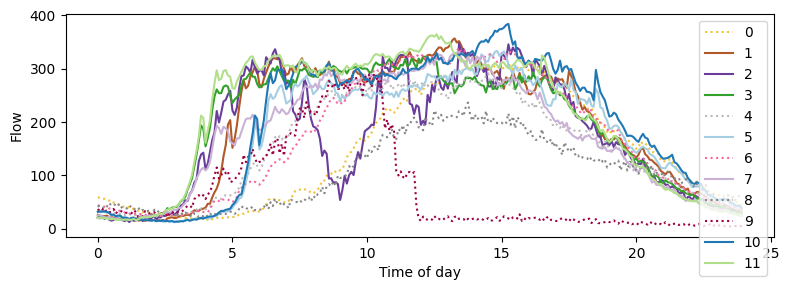

Algorithm: Agglomerative
Parameters: (15, None, None)
cluster_id_weekdays_share [5, 32, 28, 17, 8, 32, 2, 2, 3, 1, 43, 58, 1, 3, 1]
cluster_id_weekend_share [42, 0, 0, 0, 11, 0, 23, 0, 2, 2, 0, 0, 21, 0, 0]


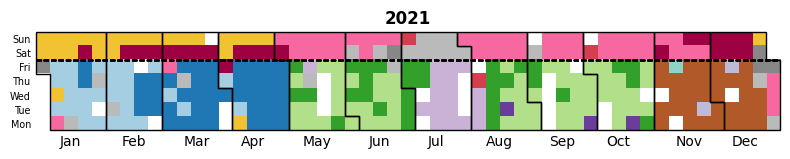

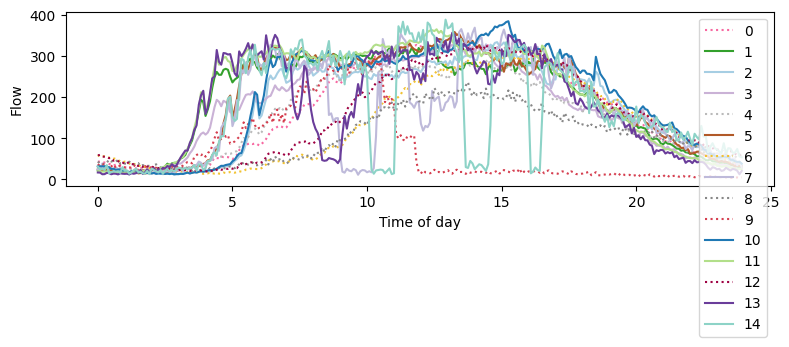

Algorithm: DBSCAN
Parameters: (None, 500, 2)
cluster_id_weekdays_share [2, 37, 3, 32, 14, 3, 145]
cluster_id_weekend_share [44, 0, 35, 0, 0, 0, 22]


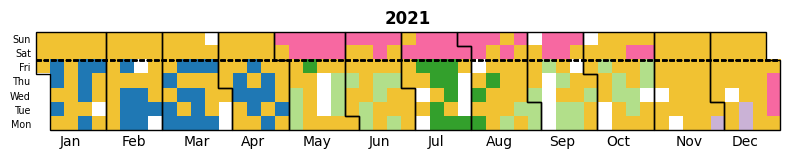

<ipython-input-31-47cc0916e5e0>:17: RuntimeWarning: Mean of empty slice
  centroid_yy = list(np.nanmean(vectorized_train_dataset_no_nans[np.where(cluster_labels == j)[0], :], 0).transpose())


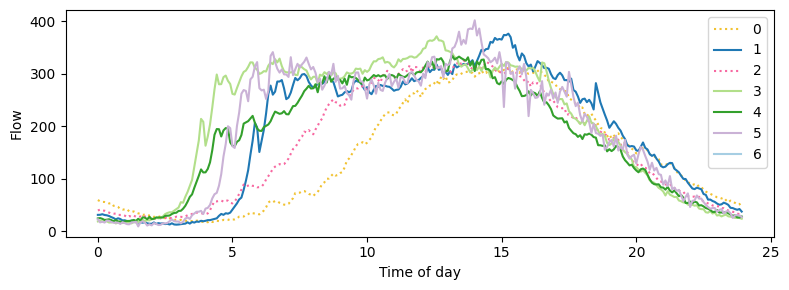

Algorithm: DBSCAN
Parameters: (None, 500, 3)
cluster_id_weekdays_share [2, 37, 3, 32, 14, 3, 145]
cluster_id_weekend_share [44, 0, 35, 0, 0, 0, 22]


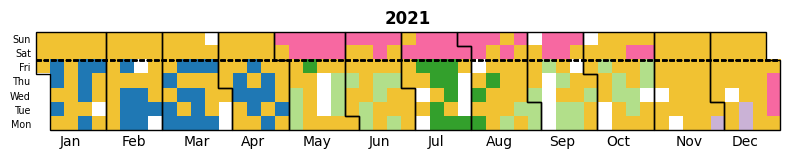

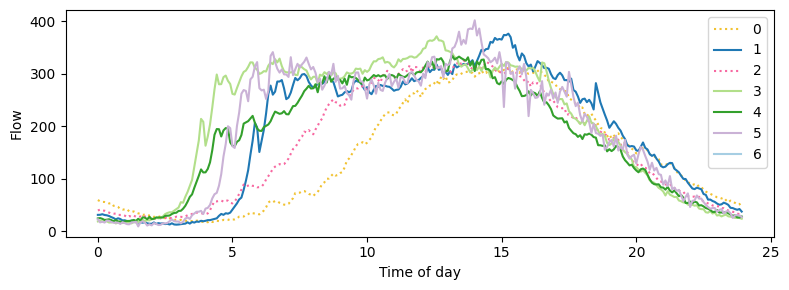

Algorithm: DBSCAN
Parameters: (None, 500, 5)
cluster_id_weekdays_share [2, 31, 3, 13, 27, 160]
cluster_id_weekend_share [44, 0, 35, 0, 0, 22]


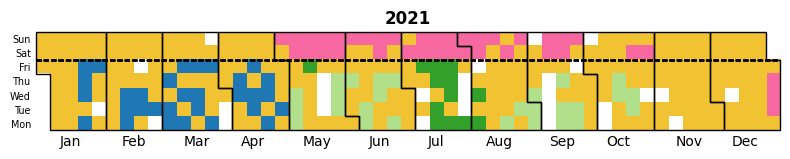

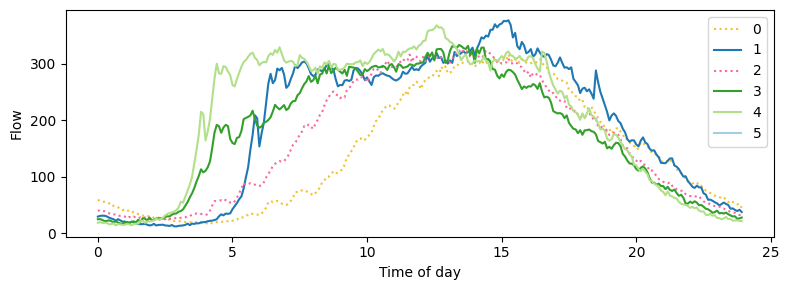

Algorithm: GMM
Parameters: (3, None, None)
cluster_id_weekdays_share [134, 94, 8]
cluster_id_weekend_share [0, 26, 75]


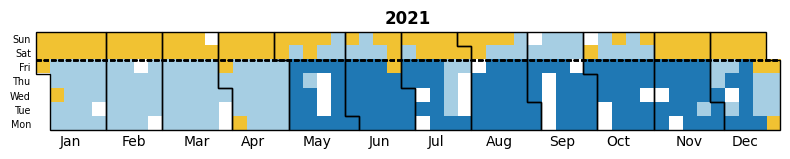

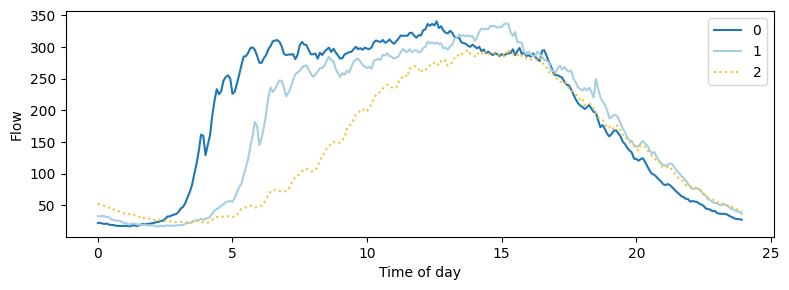

Algorithm: GMM
Parameters: (5, None, None)
cluster_id_weekdays_share [2, 14, 110, 104, 6]
cluster_id_weekend_share [2, 56, 0, 0, 43]


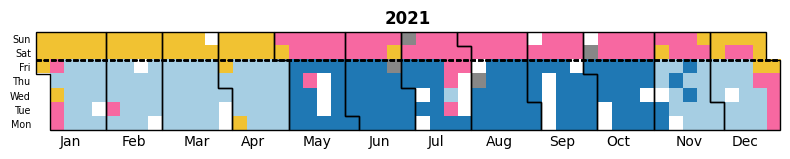

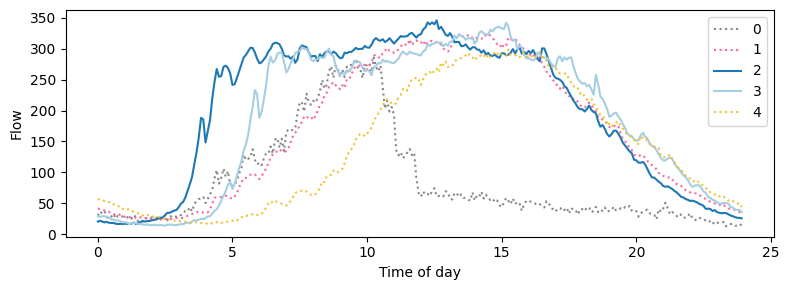

Algorithm: GMM
Parameters: (7, None, None)
cluster_id_weekdays_share [94, 8, 52, 2, 1, 6, 73]
cluster_id_weekend_share [0, 56, 0, 2, 0, 43, 0]


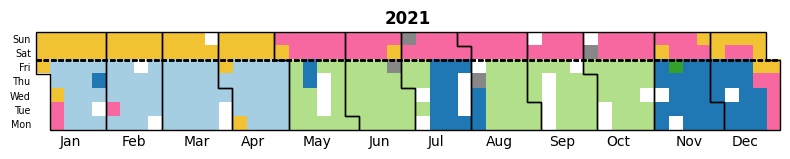

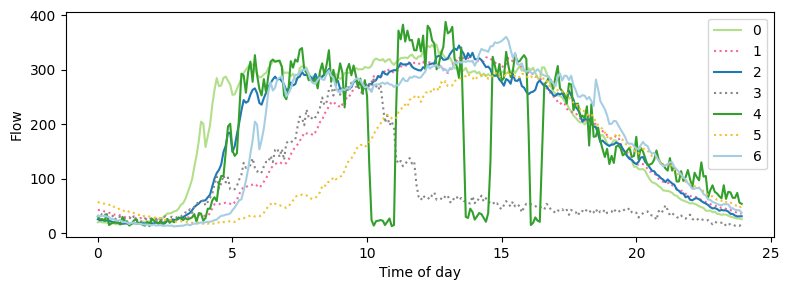

Algorithm: GMM
Parameters: (9, None, None)
cluster_id_weekdays_share [1, 32, 94, 5, 46, 45, 12, 1, 0]
cluster_id_weekend_share [2, 0, 0, 16, 0, 0, 26, 34, 23]


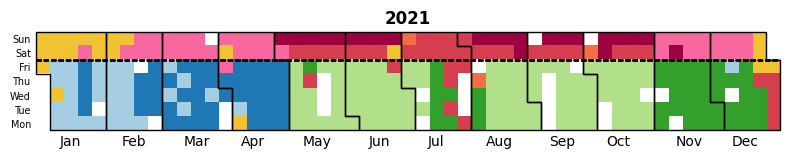

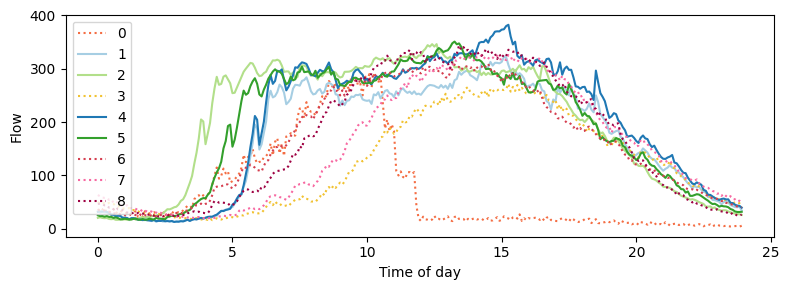

Algorithm: GMM
Parameters: (12, None, None)
cluster_id_weekdays_share [31, 59, 5, 29, 34, 5, 1, 43, 1, 8, 20, 0]
cluster_id_weekend_share [0, 0, 18, 0, 0, 16, 2, 0, 35, 7, 0, 23]


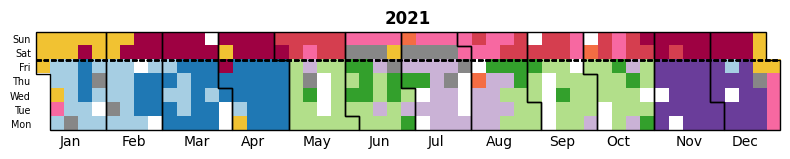

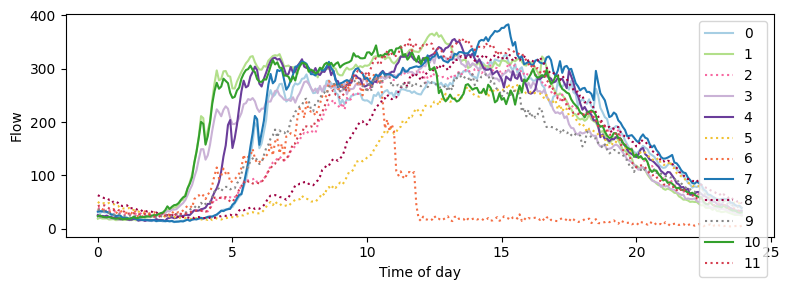

Algorithm: GMM
Parameters: (15, None, None)
cluster_id_weekdays_share [0, 2, 62, 1, 1, 10, 22, 5, 34, 5, 1, 1, 30, 35, 27]
cluster_id_weekend_share [19, 0, 0, 28, 2, 0, 0, 10, 0, 18, 24, 0, 0, 0, 0]


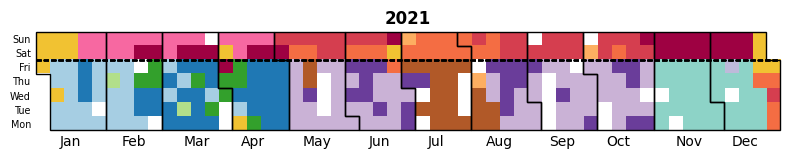

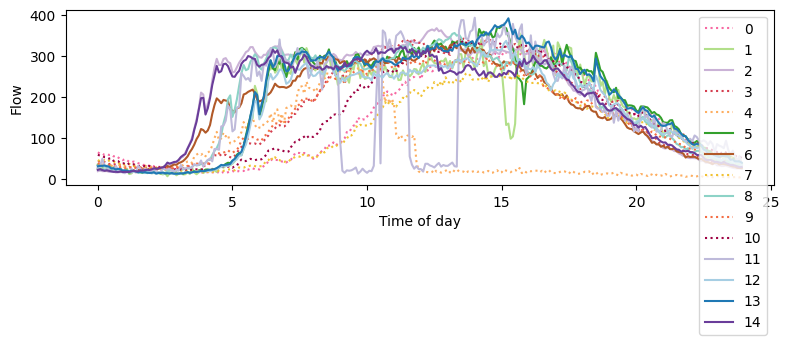

In [31]:
for i in range(len(clusters)):
  print(f'Algorithm: {clusters[i][0]}\nParameters: {clusters[i][1], clusters[i][2], clusters[i][3]}')
  cluster_labels = clusters[i][4]
  n_clusters_t = len(np.unique(cluster_labels))

  # Calendar visualization
  days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, train_dates_no_nans, cluster_labels)
  make_calendar_visualization_figure(train_dates_no_nans, cluster_labels, n_clusters_t, [2021], days_colors, color_to_cluster, save_figure=None)

  # Centroids visualization
  centroids_xx = []
  centroids_yy_daytypes = []
  cluster_ids = []

  for j in range(0, n_clusters_t):
      centroids_xx.append(x_axis_hours)
      centroid_yy = list(np.nanmean(vectorized_train_dataset_no_nans[np.where(cluster_labels == j)[0], :], 0).transpose())
      centroids_yy_daytypes.append(centroid_yy)
      cluster_ids.append(j)

  make_figure_centroids(centroids_xx, centroids_yy_daytypes, color_to_cluster, style_to_cluster, cluster_ids)